# Trust Region Policy Optimization (TRPO)

> Trust Region Policy Optimization (TRPO) is a policy optimization algorithm in reinforcement learning designed to ensure stable and monotonic policy improvements. It addresses challenges in policy optimization, such as avoiding large policy updates that could lead to policy degradation or instability. Below is a detailed explanation of TRPO:

__Objective Function:__
- TRPO aims to maximize the expected cumulative return from the policy while ensuring that the policy update is within a specified trust region. The objective function is as follows:
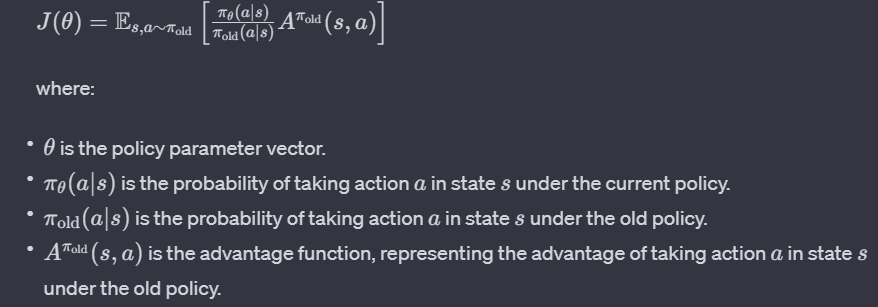

__Trust Region Constraint:__
- To ensure stable policy updates, TRPO introduces a constraint on the policy update. The policy update is constrained by a "trust region" to prevent large changes. The objective is to find a policy update direction $d$ such that the policy after the update $π_{Θ+ad}$ maximizes the objective function while staying close to the old policy:

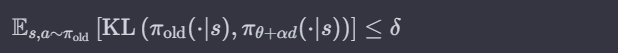


Here, $a$ is the step size, and $δ$ is a hyperparameter representing the size of the trust region.




__Optimization__

- TRPO optimizes the policy by solving the following constrained optimization problem:
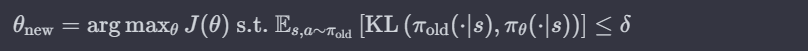


The optimization is typically performed using conjugate gradient methods or other numerical optimization techniques.

In [ ]:
!apt-get install -y xvfb

!pip install gym==0.23.1 \
    pytorch-lightning==1.6 \
    pyvirtualdisplay

!pip install -U brax==0.0.12 jax==0.3.14 jaxlib==0.3.14+cuda11.cudnn82 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

import warnings
warnings.filterwarnings('ignore')

__Advantages__

1. __Monotonic Improvement__:

  - TRPO guarantees a monotonic improvement in the policy, preventing performance degradation during training.

2. __Stable Updates__:

  - The trust region constraint ensures that policy updates are limited, preventing large policy changes that could lead to instability.

3. __Compatible with Function Approximation:__

  - TRPO can be used with function approximation methods, such as neural networks, to represent complex policies in high-dimensional state and action spaces.

4. __Sample Efficiency:__

  - TRPO often achieves good sample efficiency, requiring fewer samples than some other policy optimization algorithms.

#### Setup virtual display

In [2]:
from pyvirtualdisplay import Display
Display(visible=False, size=(1400, 900)).start()

#### Import the necessary code libraries

In [3]:
import copy
import torch
import random
import gym
import matplotlib
import functools
import itertools
import math

import numpy as np
import matplotlib.pyplot as plt

import torch.nn.functional as F

from collections import deque, namedtuple
from IPython.display import HTML
from base64 import b64encode

from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import IterableDataset
from torch.optim import AdamW, Optimizer
# kl_divergence:
# -> Compute Kullback-Leibler divergence KL(p \| q) between two distributions
from torch.distributions import Normal, kl_divergence

from pytorch_lightning import LightningModule, Trainer

import brax
from brax import envs
from brax.envs import to_torch
from brax.io import html

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
num_gpus = torch.cuda.device_count()

v = torch.ones(1, device='cuda')

/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/dtypes.py:35: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  from tensorflow.tsl.python.lib.core import pywrap_ml_dtypes
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/__init__.py:38: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('pytorch_lightning')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_namespace(__name__)


In [4]:
@torch.no_grad()
def create_video(env, episode_length, policy=None):
  """
  Creating a video
  """
  qp_array = []
  state = env.reset()
  for i in range(episode_length):
    if policy:
      loc, scale = policy(state)
      sample = torch.normal(loc, scale)
      action = torch.tanh(sample)
    else:
      action = env.action_space.sample()
    state, _, _, _ = env.step(action)
    qp_array.append(env.unwrapped._state.qp)
  return HTML(html.render(env.unwrapped._env.sys, qp_array))


@torch.no_grad()
def test_agent(env, episode_length, policy, episodes=10):
  """
  test the agent.
  """
  ep_returns = []
  for ep in range(episodes):
    state = env.reset()
    done = False
    ep_ret = 0.0

    while not done:
      loc, scale = policy(state)
      sample = torch.normal(loc, scale)
      action = torch.tanh(sample)
      state, reward, done, info = env.step(action)
      ep_ret += reward.item()

    ep_returns.append(ep_ret)

  return sum(ep_returns) / episodes

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Create the policy

In [5]:
class GradientPolicy(nn.Module):
  """
  Gradient policy ANN.

  return the mean & std, as the moments of action probability distribution.
  """
  def __init__(self, in_features, out_dims, hidden_size=128):
    super().__init__()
    self.fc1 = nn.Linear(in_features, hidden_size)
    self.fc2 = nn.Linear(hidden_size, hidden_size)
    self.fc_mu = nn.Linear(hidden_size, out_dims)
    self.fc_std = nn.Linear(hidden_size, out_dims)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))

    loc = self.fc_mu(x)
    loc = torch.tanh(loc)

    scale = self.fc_std(x)
    scale = F.softplus(scale) + 0.001
    return loc, scale

#### Create the value network

In [6]:
class ValueNet(nn.Module):
  """
  The Value network. predict and return the V(s).
  """

  def __init__(self, in_features, hidden_size=128):
    super().__init__()
    self.fc1 = nn.Linear(in_features, hidden_size)
    self.fc2 = nn.Linear(hidden_size, hidden_size)
    self.fc3 = nn.Linear(hidden_size, 1)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

#### Create the environment

In [7]:
class RunningMeanStd:
  """
  Compute the running mean & std more efficiently.

  https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Parallel_algorithm
  """
  def __init__(self, epsilon=1e-4, shape=()):
      self.mean = torch.zeros(shape, dtype=torch.float32).to(device)
      self.var = torch.ones(shape, dtype=torch.float32).to(device)
      self.count = epsilon

  def update(self, x):
      batch_mean = torch.mean(x, dim=0)
      batch_var = torch.var(x, dim=0)
      batch_count = x.shape[0]
      self.update_from_moments(batch_mean, batch_var, batch_count)

  def update_from_moments(self, batch_mean, batch_var, batch_count):
      self.mean, self.var, self.count = update_mean_var_count_from_moments(
          self.mean, self.var, self.count, batch_mean, batch_var, batch_count
      )


def update_mean_var_count_from_moments(
    mean, var, count, batch_mean, batch_var, batch_count
):
    delta = batch_mean - mean
    tot_count = count + batch_count

    new_mean = mean + delta * batch_count / tot_count
    m_a = var * count
    m_b = batch_var * batch_count
    M2 = m_a + m_b + torch.square(delta) * count * batch_count / tot_count
    new_var = M2 / tot_count
    new_count = tot_count

    return new_mean, new_var, new_count


class NormalizeObservation(gym.core.Wrapper):
  """
  normalize the observation in the environment.
  """

  def __init__(self, env, epsilon=1e-8):
      super().__init__(env)
      self.num_envs = getattr(env, "num_envs", 1)
      self.obs_rms = RunningMeanStd(shape=self.observation_space.shape[-1])
      self.epsilon = epsilon

  def step(self, action):
      obs, rews, dones, infos = self.env.step(action)
      obs = self.normalize(obs)
      return obs, rews, dones, infos

  def reset(self, **kwargs):
      return_info = kwargs.get("return_info", False)
      if return_info:
          obs, info = self.env.reset(**kwargs)
      else:
          obs = self.env.reset(**kwargs)
      obs = self.normalize(obs)
      if not return_info:
          return obs
      else:
          return obs, info

  def normalize(self, obs):
      self.obs_rms.update(obs)
      return (obs - self.obs_rms.mean) / torch.sqrt(self.obs_rms.var + self.epsilon)


In [8]:
# Add the `brax-ant-v0` environment to the gym library
entry_point = functools.partial(envs.create_gym_env, env_name='ant')
gym.register('brax-ant-v0', entry_point=entry_point)

In [9]:
# Create the env
env = gym.make("brax-ant-v0", episode_length=1000)
env = to_torch.JaxToTorchWrapper(env, device=device)

# play with a random policy
create_video(env, 1000)

In [10]:
def create_env(env_name, num_envs=256, episode_length=1000):
  """
  Create env(s)
  """
  env = gym.make(env_name, batch_size=num_envs, episode_length=episode_length)
  env = to_torch.JaxToTorchWrapper(env, device=device)
  env = NormalizeObservation(env)
  return env

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
# create `num_envs` env(s)
env = create_env('brax-ant-v0', num_envs=10)
obs = env.reset()
print("Num envs: ", obs.shape[0], "Obs dimentions: ", obs.shape[1])

Num envs:  10 Obs dimentions:  87


In [12]:
# the action space:
env.action_space

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Box(-1.0, 1.0, (10, 8), float32)

In [13]:
obs, reward, done, info = env.step(env.action_space.sample())

In [14]:
info.keys()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


dict_keys(['reward_contact_cost', 'reward_ctrl_cost', 'reward_forward', 'reward_survive'])

#### TRPO optimizer
__a set of functions and a class for implementing an optimizer based on the Conjugate Gradient method with line search, particularly designed for constrained optimization problems. The optimizer is intended for use in reinforcement learning tasks with a trust region constraint.__

In [15]:
# Adapted from: https://github.com/rlworkgroup/garage/blob/master/src/garage/torch/optimizers/conjugate_gradient_optimizer.py


def unflatten_tensors(flattened, tensor_shapes):
  """
  This function takes a flattened tensor and a list of tensor shapes
  and returns a list of tensors with the specified shapes.
  It is used to reshape a flattened vector into a list
  of tensors representing model parameters.
  """
  flattened = flattened.cpu()
  tensor_sizes = list(map(np.prod, tensor_shapes))
  indices = np.cumsum(tensor_sizes)[:-1]
  return [
      np.reshape(pair[0], pair[1]).to(device)
      for pair in zip(np.split(flattened, indices), tensor_shapes)
  ]


def _build_hessian_vector_product(func, params, reg_coeff=1e-5):
  """
  This function builds a Hessian-vector product function based on a
  given objective function (func) and model parameters (params).
  The Hessian-vector product is used in the conjugate gradient optimization.
  """
    param_shapes = [p.shape or torch.Size([1]) for p in params]
    f = func()
    f_grads = torch.autograd.grad(f, params, create_graph=True)

    def _eval(vector):
      """
      This function evaluates the Hessian-vector product for a given vector.
      It utilizes the previously built Hessian-vector product function.
      """
      unflatten_vector = unflatten_tensors(vector, param_shapes)


      assert len(f_grads) == len(unflatten_vector)
      grad_vector_product = torch.sum(
          torch.stack(
              [torch.sum(g * x) for g, x in zip(f_grads, unflatten_vector)]))

      hvp = list(
          torch.autograd.grad(grad_vector_product, params,
                              retain_graph=True))
      for i, (hx, p) in enumerate(zip(hvp, params)):
          if hx is None:
              hvp[i] = torch.zeros_like(p)

      flat_output = torch.cat([h.reshape(-1) for h in hvp])
      return flat_output + reg_coeff * vector

    return _eval


def _conjugate_gradient(f_Ax, b, cg_iters, residual_tol=1e-10):
  """
  Compute the direction of the optimization
  without having to build the hessian matrix entirely.
  """
    p = b.clone()
    r = b.clone()
    x = torch.zeros_like(b)
    rdotr = torch.dot(r, r)

    for _ in range(cg_iters):
        z = f_Ax(p)
        v = rdotr / torch.dot(p, z)
        x += v * p
        r -= v * z
        newrdotr = torch.dot(r, r)
        mu = newrdotr / rdotr
        p = r + mu * p

        rdotr = newrdotr
        if rdotr < residual_tol:
            break
    return x


class ConjugateGradientOptimizer(Optimizer):
  """
  This class defines a custom optimizer that uses the Conjugate Gradient
  method for constrained optimization. It inherits from the Optimizer class,
  indicating it's designed to be used as an optimizer in a PyTorch model.
  """

    def __init__(self, params, max_constraint_value, cg_iters=10, max_backtracks=15,
                 backtrack_ratio=0.8, hvp_reg_coeff=1e-5, accept_violation=False):

        super().__init__(params, {})
        self._max_constraint_value = max_constraint_value
        self._cg_iters = cg_iters
        self._max_backtracks = max_backtracks
        self._backtrack_ratio = backtrack_ratio
        self._hvp_reg_coeff = hvp_reg_coeff
        self._accept_violation = accept_violation


    def step(self, closure):
      f_loss, f_constraint = closure()
      params = []
      grads = []
      for group in self.param_groups:
          for p in group['params']:
              if p.grad is not None:
                  params.append(p)
                  grads.append(p.grad.reshape(-1))

      flat_loss_grads = torch.cat(grads)
      f_Ax = _build_hessian_vector_product(f_constraint, params, self._hvp_reg_coeff)
      step_dir = _conjugate_gradient(f_Ax, flat_loss_grads, self._cg_iters)

      step_dir[step_dir.ne(step_dir)] = 0.

      step_size = np.sqrt(2.0 * self._max_constraint_value * (1. / (torch.dot(step_dir, f_Ax(step_dir)) + 1e-8)).cpu())

      if np.isnan(step_size):
          step_size = 1.

      descent_step = step_size * step_dir
      self._backtracking_line_search(params, descent_step, f_loss, f_constraint)


    def _backtracking_line_search(self, params, descent_step, f_loss, f_constraint):
        """
       Implements a backtracking line search to find a
       suitable step size for the optimization.
        """
        prev_params = [p.clone() for p in params]
        ratio_list = self._backtrack_ratio**np.arange(self._max_backtracks)
        loss_before = f_loss()

        param_shapes = [p.shape or torch.Size([1]) for p in params]
        descent_step = unflatten_tensors(descent_step, param_shapes)
        assert len(descent_step) == len(params)

        for ratio in ratio_list:
            for step, prev_param, param in zip(descent_step, prev_params, params):
                step = ratio * step
                new_param = prev_param.data - step
                param.data = new_param.data

            loss = f_loss()
            constraint_val = f_constraint()
            if (loss < loss_before and constraint_val <= self._max_constraint_value):
                break

This optimizer is designed for use in constrained optimization problems, where there is a need to respect a maximum constraint value during updates. The Conjugate Gradient method is used to efficiently compute the optimization direction without explicitly forming the Hessian matrix. The line search ensures that the step size satisfies the trust region constraint. The optimizer is applied to both the main loss (f_loss) and a constraint function (f_constraint).

## Create the dataset

In [16]:
class RLDataset(IterableDataset):
  """
  An iterable data set that capable to use with TRPO algorithm.
  """
  def __init__(self, env, policy, value_net, samples_per_epoch, gamma, lamb):

    self.samples_per_epoch = samples_per_epoch
    self.gamma = gamma
    self.lamb = lamb
    self.env = env
    self.policy = policy
    self.value_net = value_net
    self.obs = self.env.reset()

  @torch.no_grad()
  def __iter__(self):
    ## Generate (samples) transitions:
    transitions = []
    for step in range(self.samples_per_epoch):
      loc, scale = self.policy(self.obs)
      action = torch.normal(loc, scale)
      next_obs, reward, done, info = self.env.step(action)
      transitions.append((self.obs, loc, scale, action, reward, done, next_obs))
      self.obs = next_obs

    ## turn the components of the transition into tensors:
    transitions = map(torch.stack, zip(*transitions))
    obs_b, loc_b, scale_b, action_b, reward_b, done_b, next_obs_b = transitions
    reward_b = reward_b.unsqueeze(dim=-1)
    done_b = done_b.unsqueeze(dim=-1)

    # compute the V(s) and V(s')
    values_b = self.value_net(obs_b)           # V(s)
    next_values_b = self.value_net(next_obs_b) # V(s')

    # compute the RD residual
    td_error_b = reward_b + (1 - done_b) * self.gamma * next_values_b - values_b

    # initial arrays for compute the GEA for each time step (for each row.)
    running_gae = torch.zeros((self.env.num_envs, 1), dtype=torch.float32, device=device)
    gae_b = torch.zeros_like(td_error_b)

    # Compute the running GEA and update the GEA for each time step
    for row in range(self.samples_per_epoch - 1, -1, -1):
      running_gae = td_error_b[row] + (1 - done_b[row]) * self.gamma * self.lamb * running_gae
      gae_b[row] = running_gae

    # compute the target
    target_b = gae_b + values_b

    ## reshape batches for shuffle the samples and return that.
    num_samples = self.samples_per_epoch * self.env.num_envs
    reshape_fn = lambda x: x.view(num_samples, -1)
    batch = [obs_b, loc_b, scale_b, action_b, reward_b, gae_b, target_b]

    obs_b, loc_b, scale_b, action_b, reward_b, gae_b, target_b = map(reshape_fn, batch)

    idx = list(range(num_samples))
    random.shuffle(idx)

    for i in idx:
      yield obs_b[i], loc_b[i], scale_b[i], action_b[i], reward_b[i], gae_b[i], target_b[i]

# Create TRPO with generalized advantage estimation (GAE)

In [17]:
class TRPO(LightningModule):
  """
  Create TRPO with generalized advantage estimation (GAE).

  Parameters:
  -----------
  - `env_name:` The name of the environment.
  - `num_envs:` Number of parallel environments (2048 by default).
  - `episode_length:` Maximum length of an episode (1000 by default).
  - `batch_size:` Batch size for optimization (2048 by default).
  - `hidden_size:` Size of the hidden layer in the neural network models (256 by default).
  - `samples_per_epoch:` Number of samples collected per epoch (20 by default).
  - `value_lr:` Learning rate for the value network (1e-3 by default).
  - `gamma:` Discount factor (0.99 by default).
  - `lamb:` Lambda parameter for Generalized Advantage Estimation (GAE) (0.95 by default).
  - `kl_limit:` KL divergence limit for the Conjugate Gradient optimizer (0.25 by default).
  - `v_optim:` Value network optimizer (AdamW by default).
  - `pi_optim:` Policy optimizer (ConjugateGradientOptimizer by default).

  """

  def __init__(self, env_name, num_envs=2048, episode_length=1000,
               batch_size=2048, hidden_size=256, samples_per_epoch=20,
               value_lr=1e-3, gamma=0.99, lamb=0.95,  kl_limit=0.25,
               v_optim=AdamW, pi_optim=ConjugateGradientOptimizer):

    super().__init__()

    self.env = create_env(env_name, num_envs=num_envs, episode_length=episode_length)
    test_env = gym.make(env_name, episode_length=episode_length)
    test_env = to_torch.JaxToTorchWrapper(test_env, device=device)
    self.test_env = NormalizeObservation(test_env)
    self.test_env.obs_rms = self.env.obs_rms

    obs_size = self.env.observation_space.shape[1]
    action_dims = self.env.action_space.shape[1]

    self.policy = GradientPolicy(obs_size, action_dims, hidden_size)
    self.value_net = ValueNet(obs_size, hidden_size)
    self.target_value_net = copy.deepcopy(self.value_net)

    self.pi_optim = ConjugateGradientOptimizer(self.policy.parameters(), max_constraint_value=kl_limit)

    self.dataset = RLDataset(self.env, self.policy, self.target_value_net,
                             samples_per_epoch, gamma, lamb)

    self.save_hyperparameters()
    self.videos = []

    # set to false (for use ConjugateGradientOptimizer insted the default optimizer).
    # `automatic_optimization` is a property that we inherit from Pytorch.
    self.automatic_optimization = False

  def configure_optimizers(self):
    """
    Configure the optimizers of Value and Policy ANNs
    """
    # Value ANN weigths optimization
    value_opt = self.hparams.v_optim(
      self.value_net.parameters(), # hyperparameters to update
       lr=self.hparams.value_lr  # learning rate
    )

    # Policy ANN weigths optimization
    pi_optim = ConjugateGradientOptimizer(
        self.policy.parameters(), # hyperparameters to update
        max_constraint_value=self.hparams.kl_limit # the location of our test region boundry
      )
    return [value_opt, pi_optim]

  def train_dataloader(self):
    """
    Create training data loader.
    """
    return DataLoader(dataset=self.dataset, # our dataset instance
                      batch_size=self.hparams.batch_size) # batch size

  def training_step(self, batch, batch_idx):
    """
    Execute a training step with a batch of data.

    Parameters:
    -----------
    - `batch`: the batch that contain the data tensors
    - `batch_idx`: the index of this batch
    """

    # get the tensors from the batch:
    # (s,mean,std,a,r,GEA,target)
    obs_b, loc_b, scale_b, action_b, reward_b, gae_b, target_b = batch

    # get the Value/Policy optimizers
    v_optim, pi_optim = self.optimizers()

    # ---------- Update the value netwoek ------------ #

    # 1. predict the state
    state_values = self.value_net(obs_b)
    # 2. compute the loss between the state and target
    v_loss = F.smooth_l1_loss(state_values, target_b)
    self.log("episode/Value Loss", v_loss)
    # 3. after we compute the loss, let's update the Value network:
    v_optim.zero_grad()
    self.manual_backward(v_loss) # by our own optimizer.
    v_optim.step()

    # ---------- Update the Policy network ------------#

    ## New policy
    # 1. predict the new mean & std by the New Policy!
    new_loc, new_scale = self.policy(obs_b)
    # 2. create the action probability normal distribution
    dist = Normal(new_loc, new_scale)
    # 3. compute the log probability of the action in our distribution
    log_prob = dist.log_prob(action_b).sum(dim=-1, keepdim=True)

    ## Old Policy
    # 4. create the previous normal distribution (by the predition of the previous Policy)
    prev_dist = Normal(loc_b, scale_b)
    # 5. compute the log probability of the action in our distribution
    prev_log_prob = prev_dist.log_prob(action_b).sum(dim=-1, keepdim=True)

    # 6. Our optimizer must to call the `loss_fn()` several times to take
    #    an optimization step.
    def loss_fn():
      """
      compute the minus exponent loss between the
      current log probability and the previous log probability
      of the action in the normal distribution, multily
      by the advantage (GAE).
      """
      loss = - torch.exp(log_prob - prev_log_prob) * gae_b
      return loss.mean()

    # 7. Compute the constraint value
    def constraint_fn():
      """
      Compute the Kullback-Leibler (KL) Divergence:
      It tells us how much two distributions differ from each other.
      In this case, each distribution represents the policy output,
      helping us monitor the extent to which policies change.

      The goal is to stabilize learning, which means preventing significant
      gaps between two policies. A large KL Divergence implies a substantial
      difference between the current policy (dist) and the previous policy (prev_dist).
      This constraint is crucial in Trust Region Policy Optimization (TRPO) to ensure
      that policy updates are within a specified trust region, preventing overly large changes.
      """
      constraint = kl_divergence(prev_dist, dist).sum(dim=-1)
      return constraint.mean()

    # combain the `loss_fn()` and `constraint_fn()` into lambda function
    closure = lambda: (loss_fn, constraint_fn)

    # take the loss
    loss = loss_fn()

    # Optimizer the Policy network
    pi_optim.zero_grad()
    # (retain_graph = True =
    #  we can compute the gradient with graph of operations, step by step)
    self.manual_backward(loss, retain_graph=True)
    # After we compute the gradients using `manual_backward()`,
    # we can update the Policy Network.
    # the optimizer will take these values and it will use them to
    # perform the search for the optimal step!.
    pi_optim.step(closure)


    self.log("episode/Policy Loss", loss)
    self.log("episode/Reward", reward_b.mean())


  def training_epoch_end(self, training_step_outputs):
    """
    Callback function when the training epoch is done.
    """
    # Update the weigths of the `target_value_net` by the weigths of `value_net`
    self.target_value_net.load_state_dict(self.value_net.state_dict())

    # Test the agent each 10 epochs
    if self.current_epoch % 10 == 0:
      average_return = test_agent(self.test_env, self.hparams.episode_length, self.policy, episodes=1)
      self.log("episode/Average Return", average_return)

    # Each 50 epochs produce a video.
    if self.current_epoch % 50 == 0:
      video = create_video(self.test_env, self.hparams.episode_length, policy=self.policy)
      self.videos.append(video)

#### Purge logs and run the visualization tool (Tensorboard)

In [ ]:
# Start tensorboard.
!rm -r /content/lightning_logs/
!rm -r /content/videos/
%load_ext tensorboard
%tensorboard --logdir /content/lightning_logs/

#### Train the policy

In [19]:
algo = TRPO('brax-ant-v0')

trainer = Trainer(gpus=num_gpus, max_epochs=1000)

trainer.fit(algo)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/torch/distributed/_sharded_tensor/__init__.py:8: DeprecationWarning: torch.distributed._sharded_tensor will be deprecated, use torch.distributed._shard.sharded_tensor instead
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_l

Training: 0it [00:00, ?it/s]

In [20]:
algo.videos[-1]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
